In [1]:
from math import fmod
import numpy as np
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
from orbital.constants import earth_mu, earth_radius_equatorial
from orbital.utilities import elements_from_state_vector, mean_anomaly_from_true
from pysatrec import PySatrec

#Default limitation values
_TTL  = 31.         # Time to live in days  
_MAXR = 152000e+3   # Apogee of the highest orbit ("Intergal")
_MINR = earth_radius_equatorial + 160e+3  # Perigee of the lowest orbit (stratosphere, LOL)
_MAXN = np.sqrt(earth_mu/_MINR**3) * 60. # Highest mean motion
_MINN = np.sqrt(earth_mu/_MAXR**3) * 60. # Lowest mean motion

_D2R   = np.pi/180.      # Degrees to radians
_MPD   = 1440.           # Minutes in day
_XD2RM = _MPD/(2.*np.pi) # rounds/ray. -> radians/minute

#State sdt will be machine epsilones for values in TLE
_AEPS = .5e-4 * _D2R
#                  inclo,   nodeo,  ecco, argpo,     mo,     no_kozai
_EPS_TLE = np.array([_AEPS,  _AEPS, .5e-7,  _AEPS, _AEPS, .5e-8*_XD2RM])

#State vector indexes
#Angle state dimensions
_KEP_ANG = [1,3,4]
#Number like state dimensions
#_KEP_NUM = [i for i in range(_DIMX) if i not in _KEP_ANG]
#==============================================================================
#Get initial estimate of orbital elements
def get_kepler_elements(r,v):
    kep = elements_from_state_vector(np.array(r)*1000, np.array(v)*1000, earth_mu)
    mo = mean_anomaly_from_true(kep.e, kep.f)
    no_kozai = 60.0 * (earth_mu / (kep.a**3))**0.5
    return np.array((kep.i, kep.raan, kep.e, kep.arg_pe, mo, no_kozai))

#==============================================================================
#Observation residual function
def _res_kep(a,b):
    r = a - b
    
    sa = np.sin(a[_KEP_ANG])
    ca = np.cos(a[_KEP_ANG])
    
    sb = np.sin(b[_KEP_ANG])
    cb = np.cos(b[_KEP_ANG])
    
    sr = sa * cb - ca * sb
    cr = cb * ca + sb * sa
    
    r[_KEP_ANG] = np.arctan2(sr, cr)
    
    return r
#==============================================================================
def _norm_kep(_x):
    x = _x.copy()
    for i in _KEP_ANG:
        x[i] = fmod(x[i], 2.*np.pi)
        if x[i] < 0.:
            x[i] = 2.*np.pi - x[i]
    return x
#==============================================================================
def _eval_sat(x, _epoch, _bstar):
    try:
        # Генерируем спутник
        ysat = PySatrec.new_sat(_epoch, 0, 0, _bstar, *list(x))
    
        # Моделируем его сотояние на момент "Эпохи"
        yfr, yjd = np.modf(_epoch)
        ye,yr,yv = ysat.sgp4(yjd, yfr)
    except Exception as ex:
        print(ex)
        ye = 5
    
    if ye != 0:
        return np.zeros(x.shape, dtype=np.float), ye
    
    # Возвращаем наблюдаемые значения элементов движения
    return get_kepler_elements(yr, yv), 0
#==============================================================================
def _eval_dif(dx, thr):
    return np.all(np.abs(dx) < thr * _EPS_TLE)
#==============================================================================    
# Computes SGP4 Mean Orbital Elements from state (r,v) at epoch
# See https://apps.dtic.mil/dtic/tr/fulltext/u2/a289281.pdf
def sgp4_moe_from_state(__r, __v, __epoch, __bstar=0, g0 = 1., eps=.5, 
                         stop_thr=1e-0, max_iter=1000):
    #Наблюдаемые значения
    yo = get_kepler_elements(__r,__v)

    #Начальное приближение
    x = yo.copy()

    # Коэффициенты усиления ошибок
    gains = np.ones(x.shape, dtype=np.float) * g0

    # Информация о знаках невязок
    sez = yo >= x

    exc = 0

    for j in range(max_iter):
        y, exc = _eval_sat(x, __epoch, __bstar)
        if (exc):
            break
        
        # Невязки
        e = _res_kep(yo, y)

        #Знаки невязок
        se = e > 0.
        changed = np.logical_xor(se, sez)
        sez = se

        # Если знак не менялся - увеличиваем коэффициент, 
        # если менялся - уменьшаем
        gains *= (1. + eps)*np.logical_not(changed) + (1. - eps)*changed
        gains = np.clip(gains, 0., 1.)

        dx = gains * e
        # Ограничения:
        # inclo[0, pi] ecco [0;.9999999], no_kozai [0; _MAXN]
        for i,ul in ((0, np.pi),(2, .9999999),(5, _MAXN)):

            if dx[i] == 0:
                continue

            k = 1

            if x[i] + dx[i] >= ul:
                k = dx[i]/(ul - x[i])/(1. - eps)

            if x[i] + dx[i] <= 0:
                k = abs(dx[i]/x[i])/(1. - eps)

            gains[i] /= k
            dx[i]    /= k

        x += dx

        x = _norm_kep(x)

        if _eval_dif(dx, stop_thr):
            break

    # Нормализация углов
    x = _norm_kep(x)

    return x, j, _eval_dif(dx, stop_thr), exc
#==============================================================================
# Computes SGP4 Mean Orbital Elements from arrays r,v,t
def sgp4_moe_from_arrays(r, v, t, cb=None):
    xx = []
    tt = []
    for i, ri in enumerate(r):
        x,j,c,e = sgp4_moe_from_state(ri, v[i], t[i], max_iter=50)
        
        if c:
            xx.append(x.reshape(6,1))
            tt.append(t[i])

        if cb:
            cb(i)
            
    return np.concatenate(xx, axis=1).T, np.array(tt)

In [2]:
import matplotlib.pyplot as plt
from progressbar import ProgressBar as bar
from sgp4.model import Satrec
from sgp4.api import jday
from sgp4.ext import days2mdhms

def get_sat_epoch(y, d):
    y += 2000
    return sum(jday(y, *days2mdhms(y, d)))

#Generate some data
#The Hardest one!
#l1 = '1 44249U 19029Q   20034.91667824  .00214009  00000-0  10093-1 0  9996'
#l2 = '2 44249  52.9973  93.0874 0006819 325.3043 224.0257 15.18043020  1798'
#MIN(no_kozai)
l1 = '1 40485U 15011D   20034.87500000 -.00001962  00000-0  00000+0 0  9996'
l2 = '2 40485  24.3912 120.4159 8777261  17.9050 284.4369  0.28561606 10816'
#MIN(bstar)
#l1 = '1 81358U          20028.49779613 -.00005615  00000-0 -72071+0 0  9998'
#l2 = '2 81358  62.6434  61.1979 0370276 129.5311 233.8804  9.81670356    16'
#MAX(no_kozai)
#l1 = '1 44216U 19006CS  20035.07310469  .00413944  15423-5  43386-3 0  9995'
#l2 = '2 44216  95.9131 264.4538 0065601 211.8276 147.5518 16.05814498 43974'
xs = Satrec.twoline2rv(l1, l2)

delta = float(2. * np.pi / (xs.no_kozai * 1440.))/50 #50 points per round
epoch = get_sat_epoch(xs.epochyr, xs.epochdays)      #Start of epoch
xt = np.array([epoch + delta*k for k in range(int(31./delta)+ 1)])
fr, jd = np.modf(xt)
xe,xr,xv = xs.sgp4_array(jd, fr)



pb = bar().start(len(xt))
pb.start()
moe, tt = sgp4_moe_from_arrays(xr,xv,xt,cb=pb.update)
pb.finish()

100% (443 of 443) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


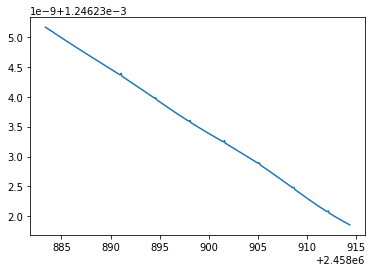

In [3]:
plt.plot(tt, moe[:,5])

In [4]:
ny = moe[:,5]

In [5]:
from scipy.optimize import leastsq

n0 = np.array([ny[0], 0, 0, 0, 0, 0, 0, 0, 0, 0])

def nt1(n, t):
    return n[0] + t*(n[1]*2 + t*(n[2]*3 + t*(n[3]*4 + t*(n[4]*5 + t*(n[5]*6 + t*(n[6]*7 + t*(n[7]*8 + t*(n[8]*9 + t*n[9]*10))))))))
    
def err_num(w, ft, t, y):
    return ft(w, t) - y

n1 = leastsq(err_num, n0, args=(nt1, tt-tt[0], ny), full_output=1)

In [6]:
n1, n0[0]

((array([ 1.24623516e-03, -4.57883578e-11, -4.78298450e-12,  1.24618534e-12,
         -1.60232653e-13,  1.13767648e-14, -4.67730257e-16,  1.10632550e-17,
         -1.39239906e-19,  7.18736815e-22]),
  array([[ 9.72712755e-02, -3.68199397e-02,  6.01070552e-03,
          -4.66181532e-04,  1.33871104e-05,  4.11827916e-07,
          -4.31545076e-08,  1.30610823e-09, -1.73107328e-11,
           8.07326854e-14],
         [-3.68199395e-02,  2.17952165e-02, -4.94941366e-03,
           5.66903897e-04, -3.56602895e-05,  1.20384163e-06,
          -1.65882369e-08, -1.55665740e-10,  7.52632656e-12,
          -6.49685970e-14],
         [ 6.01070539e-03, -4.94941359e-03,  1.48959738e-03,
          -2.21860498e-04,  1.84921913e-05, -9.01375154e-07,
           2.52887469e-08, -3.66957649e-10,  1.76329164e-12,
           7.61842012e-15],
         [-4.66181500e-04,  5.66903876e-04, -2.21860495e-04,
           3.99649298e-05, -3.89967620e-06,  2.21004946e-07,
          -7.36319513e-09,  1.37772923e-10, -1

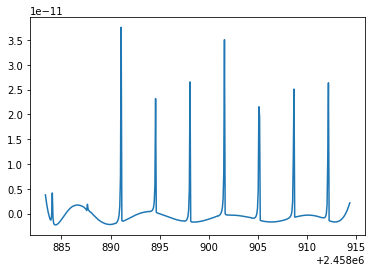

In [7]:
plt.plot(tt, ny - nt1(n1[0], tt - tt[0]))

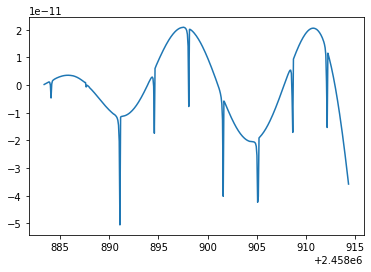

In [8]:
n20 = np.array([ny[0], 0, 0, 0, 0, 0, 0, 0, 0, 0])

def nt2(n, t):
    t2 = t*t
    t3 = t*t2
    t4 = t*t3
    return n[0]*np.power(1 - t * n[1] - t2 * n[2] - t3 * n[3] - t4 * n[4], -3)

n2 = leastsq(err_num, n20, args=(nt2, tt-tt[0], ny), full_output=1)

plt.plot(tt, err_num(n2[0], nt2, tt-tt[0], ny))

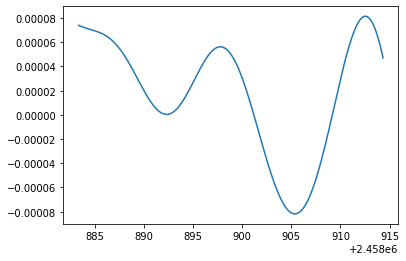

In [9]:
ey = moe[:,2]

e0 = np.array([ey[0],0,0,0,0])

def et(e, t):
    t2 = t*t
    t3 = t*t2
    t4 = t*t3
    return e[0] + e[1] * t #+ e[2] * t2 + e[3] * t3 + e[4] * t4

def err_num_p(w, ft, t, y, p):
    return np.power(ft(w, t) - y, 2*p + 1)

e1 = leastsq(err_num_p, e0, args=(et, tt-tt[0], ey, 3), full_output=1)

plt.plot(tt, err_num(e1[0], et, tt-tt[0], ey))

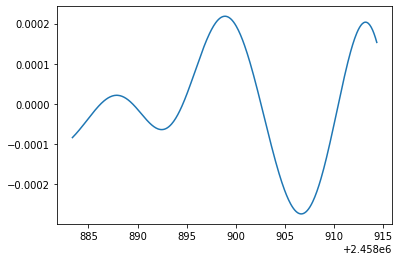

In [10]:
iy = moe[:,0]

i0 = np.array([iy[0],0,0,0,0])

def it(e, t):
    return e[0] + t*(e[1] + t * e[2])

i1 = leastsq(err_num, i0, args=(it, tt-tt[0], iy), full_output=1)

plt.plot(tt, err_num(i1[0], it, tt-tt[0], iy))

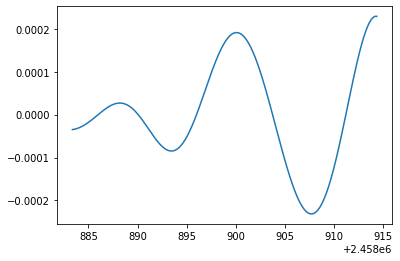

In [11]:
def _res_ang(a,b):

    sa = np.sin(a)
    ca = np.cos(a)

    sb = np.sin(b)
    cb = np.cos(b)

    sr = sa * cb - ca * sb
    cr = cb * ca + sb * sa

    return np.arctan2(sr, cr)

def err_ang(w, ft, t, y):
    return _res_ang(ft(w, t), y)

nodeoy = moe[:,1]

nodeo0 = np.array([nodeoy[0],0,0,0,0])

def nodeot(w, t):
    t2 = t*t
    t3 = t*t2
    t4 = t*t3
    return w[0] + w[1] * t + w[2] * t2# + w[3] * t3 + w[4] * t4

nodeo1 = leastsq(err_ang, nodeo0, args=(nodeot, tt-tt[0], nodeoy), full_output=1)

plt.plot(tt, err_ang(nodeo1[0], nodeot, tt-tt[0], nodeoy))

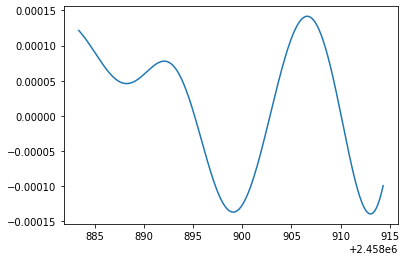

In [12]:
argpoy = moe[:,3]

argpo0 = np.array([argpoy[0],0,0,0,0])

def err_ang_p(w, ft, t, y, p):
    return np.power(_res_ang(ft(w, t), y), 2*p+1)

def argpot(w, t):
    t2 = t*t
    t3 = t*t2
    t4 = t*t3
    return w[0] + w[1] * t# + w[2] * t2# + w[3] * t3 + w[4] * t4

argpo1 = leastsq(err_ang_p, argpo0, args=(argpot, tt-tt[0], argpoy, 5), full_output=1)

plt.plot(tt, err_ang(argpo1[0], argpot, tt-tt[0], argpoy))

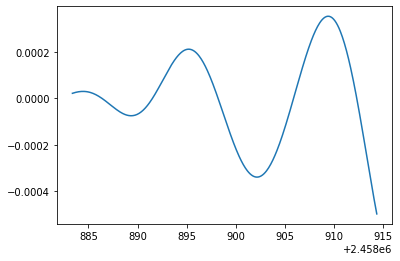

In [17]:
moy = moe[:,4]

mo0 = np.array([moy[0],0,0,0,0])

def mot(w, t):
    global n1
    global argpo1
    return n2[0][0]*1440*t+ w[0] - t*(w[1])# + t*(w[2] + t*(w[3] + t*(w[4]))))

mo1 = leastsq(err_ang, mo0, args=(mot, tt-tt[0], moy), full_output=1)

plt.plot(tt, err_ang(mo1[0], mot, tt-tt[0], moy))

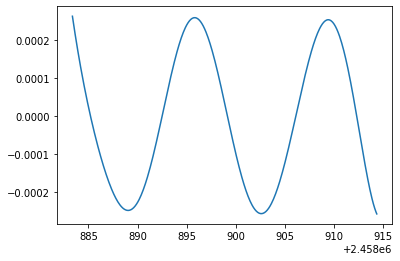

In [15]:
moy = moe[:,4]

mo0 = np.array([moy[0],0,0,0,0])

def intn1(n,t):
    return t*(n[0] + t*(n[1] + t*(n[2] + t*(n[4] + t*(n[5] + t*(n[6] + t*(n[7] + t*(n[8] + t*n[9]))))))))*1440

def mot(w, t):
    global n1
    global argpo1
    return intn1(n1[0], t) + w[0] - t*(w[1] + t*(w[2] + t*(w[3] + t*(w[4]))))

mo1 = leastsq(err_ang_p, mo0, args=(mot, tt-tt[0], moy, 5), full_output=1)

plt.plot(tt, err_ang(mo1[0], mot, tt-tt[0], moy))

In [ ]:
mo1